In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, transform= transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root= './data',train = False, download = True,
                                      transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size = 1, shuffle = False, num_workers = 2 ) 
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

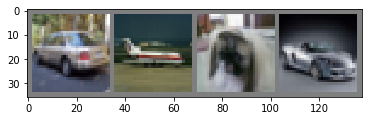

  car plane   dog   car


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

### Custom CNN Model

In [13]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

### Resnet 

In [41]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [42]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [43]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [44]:
def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def test():
    net = ResNet50()
    y = net(torch.randn(1,3,32,32))
    print(y.size())


In [321]:
class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [347]:
class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32,kernel_size = 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size =3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout_2 = nn.Dropout(0.2)
        self.dropout_3 = nn.Dropout(0.3)
        self.dropout_4 = nn.Dropout(0.4)
        self.conv3 = nn.Conv2d(in_channels = 32,  out_channels = 64,kernel_size =3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels =64,kernel_size =3)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels =128,kernel_size =3)
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels =128,kernel_size =3)
        self.conv6_bn = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*1*1,10)
    
    def forward(self,x):
        x = self.conv1_bn(F.relu(self.conv1(x)))
        x = self.pool(self.conv2_bn( F.relu(self.conv2(x)) ) ) 
        x = self.dropout_2(x)
        x = self.conv3_bn(F.relu(self.conv3(x)))
        x = self.dropout_3(self.pool(self.conv4_bn(F.relu(self.conv4(x)))))
        x = self.conv5_bn(F.relu( self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.dropout_4(self.conv6_bn(self.dropout_4(x)))
        x = x.view(-1,128*1*1)
        x = self.fc1(x)
        return x

In [14]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9
N_EPOCHS = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
#model = ImageNet()
#model = ResNet50()
#model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)

In [16]:
device

device(type='cuda')

In [17]:
def calculate_accuracy(model,loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    return (correct/total)*100

### Model Training

In [22]:
from tqdm import tqdm
import time
model.train()
for epoch in tqdm(range(N_EPOCHS)):
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(trainloader,0):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item() 
        if i%100==99:
            print(".",end='')
    running_loss/=len(trainloader)
    train_accuracy = calculate_accuracy(model,trainloader)
    test_accuracy = calculate_accuracy(model,testloader)
    time_taken = (time.time()-start)/60
    print("\nIteration: {0} | Time taken: {4} |  Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy,time_taken))
    
print("Finished")


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

.............................................................................................................................
Iteration: 1 | Time taken: 4.328860799471538 |  Loss: 0.869123536645621 | Training accuracy: 80.23599999999999% | Test accuracy: 74.09%



 10%|████████▏                                                                         | 1/10 [04:19<38:57, 259.73s/it]

.............................................................................................................................
Iteration: 2 | Time taken: 4.04272970755895 |  Loss: 0.5665365589698125 | Training accuracy: 83.458% | Test accuracy: 75.51%



 20%|████████████████▍                                                                 | 2/10 [08:22<33:56, 254.58s/it]

.............................................................................................................................
Iteration: 3 | Time taken: 4.0317097187042235 |  Loss: 0.5185879385457933 | Training accuracy: 83.52000000000001% | Test accuracy: 75.42999999999999%



 30%|████████████████████████▌                                                         | 3/10 [12:24<29:15, 250.78s/it]

.............................................................................................................................
Iteration: 4 | Time taken: 4.038672558466593 |  Loss: 0.4888121143709682 | Training accuracy: 85.846% | Test accuracy: 76.47%



 40%|████████████████████████████████▊                                                 | 4/10 [16:26<24:49, 248.24s/it]

.............................................................................................................................
Iteration: 5 | Time taken: 4.059366329511007 |  Loss: 0.4636404225014895 | Training accuracy: 86.516% | Test accuracy: 77.05%



 50%|█████████████████████████████████████████                                         | 5/10 [20:30<20:34, 246.84s/it]

.............................................................................................................................
Iteration: 6 | Time taken: 4.020380214850108 |  Loss: 0.4414266669082176 | Training accuracy: 86.966% | Test accuracy: 77.42%



 60%|█████████████████████████████████████████████████▏                                | 6/10 [24:31<16:20, 245.16s/it]

.............................................................................................................................
Iteration: 7 | Time taken: 4.0088362773259485 |  Loss: 0.42121138759799304 | Training accuracy: 86.734% | Test accuracy: 76.02%



 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [28:31<12:11, 243.77s/it]

.............................................................................................................................
Iteration: 8 | Time taken: 4.039302790164948 |  Loss: 0.4050171479382366 | Training accuracy: 89.02600000000001% | Test accuracy: 77.10000000000001%



 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [32:34<08:06, 243.35s/it]

.............................................................................................................................
Iteration: 9 | Time taken: 3.987228564421336 |  Loss: 0.39116314950734377 | Training accuracy: 88.14% | Test accuracy: 76.34%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [36:33<04:02, 242.11s/it]

.............................................................................................................................
Iteration: 10 | Time taken: 4.070839520295461 |  Loss: 0.380216148021929 | Training accuracy: 88.958% | Test accuracy: 76.66%



100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [40:37<00:00, 242.76s/it]

Finished


### Saving the model

In [70]:
torch.save(model.state_dict(), 'cifar10_best_new')

## Fast Gradient Sign Method Attack

* Objective: To generate an instance that would maximize the loss
 ![gradient.png](gradient.png)
 ![update.png](update.png)


Epsilon is quite small to avoid any obvious changes to the images

 ![example.png](example.png)

In [24]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Testing the FGSM attack

In [40]:
def test( model,attack_loss, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        # Calculate the loss
        loss = attack_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Attack effectiveness vs Epsilon

In [42]:
accuracies = []
examples = []
epsilons = [0,0.05,0.1,0.15,0.2,0.25,0.3]
# Run test for each epsilon
attack_loss = nn.CrossEntropyLoss()
for eps in epsilons:
    acc, ex = test(model,attack_loss, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 3682 / 10000 = 0.3682
Epsilon: 0.05	Test Accuracy = 1780 / 10000 = 0.178
Epsilon: 0.1	Test Accuracy = 1443 / 10000 = 0.1443
Epsilon: 0.15	Test Accuracy = 1286 / 10000 = 0.1286
Epsilon: 0.2	Test Accuracy = 1237 / 10000 = 0.1237
Epsilon: 0.25	Test Accuracy = 1153 / 10000 = 0.1153
Epsilon: 0.3	Test Accuracy = 1139 / 10000 = 0.1139


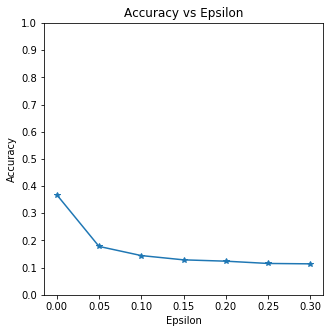

In [43]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Adversarial training

Simplest way to tackle FGSM is to train the model with some adversarial samples themselves. 

In [136]:
import copy 
model_adv = copy.deepcopy(model)
criterion_adv = nn.CrossEntropyLoss()
optimizer_adv = optim.Adam(model_adv.parameters(),lr = LEARNING_RATE)

### Pertubing for adversarial training

In [139]:
def perturb(batch_image, epsilon):
    for i,image in enumerate(batch_image):
        sign_data_grad = 1 if np.random.uniform() > 0.5 else -1 
        perturbed_image = image + epsilon*sign_data_grad
        # Adding clipping to maintain [0,1] range
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # Return the perturbed image
        batch_image[i] = perturbed_image
    return batch_image

In [135]:
N_EPOCHS_adv = 4 
EPSILON_adv = 0.05

In [151]:
model.train()
for epoch in tqdm(range(N_EPOCHS_adv)):
    running_loss = 0.0
    start = time.time()
    total=0
    for i, data in enumerate(trainloader,0):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion_adv(outputs,labels)
        loss.backward()
        optimizer_adv.step()
        running_loss+=loss.item()
        #randomly pick batches to adversarial train
        total += len(inputs)
        if np.random.uniform() > 0.5:
            inputs = perturb(inputs,EPSILON_adv)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion_adv(outputs,labels)
            loss.backward()
            optimizer_adv.step()
            running_loss+=loss.item()
            total += len(inputs)
        if i%100==99:
            print(".",end='')
    running_loss/=(total)
    train_accuracy = calculate_accuracy(model,trainloader)
    test_accuracy = calculate_accuracy(model,testloader)
    time_taken = (time.time()-start)/60
    print("\nIteration: {0} | Time taken: {4} |  Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy,time_taken))
print("Finished")




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

.............................................................................................................................
Iteration: 1 | Time taken: 6.36584286292394 |  Loss: 0.35972191089613925 | Training accuracy: 81.714% | Test accuracy: 72.94%





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:21<00:00, 381.95s/it]

Finished


In [148]:
torch.save(model.state_dict(), 'cifar10_best_adv')

### Attack on adversarial trained model

In [149]:
accuracies_adv = []
examples_adv = []
epsilons_adv = [0,0.05,0.1,0.15,0.2,0.25,0.3]
# Run test for each epsilon
attack_loss= nn.CrossEntropyLoss()
model.eval()
for eps in epsilons_adv:
    acc, ex = test(model,attack_loss, device, testloader, eps)
    accuracies_adv.append(acc)
    examples_adv.append(ex)

Epsilon: 0	Test Accuracy = 3125 / 10000 = 0.3125
Epsilon: 0.05	Test Accuracy = 1396 / 10000 = 0.1396
Epsilon: 0.1	Test Accuracy = 1118 / 10000 = 0.1118
Epsilon: 0.15	Test Accuracy = 1004 / 10000 = 0.1004
Epsilon: 0.2	Test Accuracy = 961 / 10000 = 0.0961
Epsilon: 0.25	Test Accuracy = 889 / 10000 = 0.0889
Epsilon: 0.3	Test Accuracy = 911 / 10000 = 0.0911


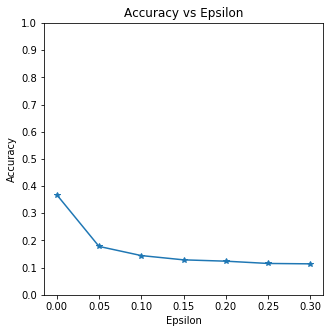

In [150]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Inspecting FGSM attacks with different epsilons

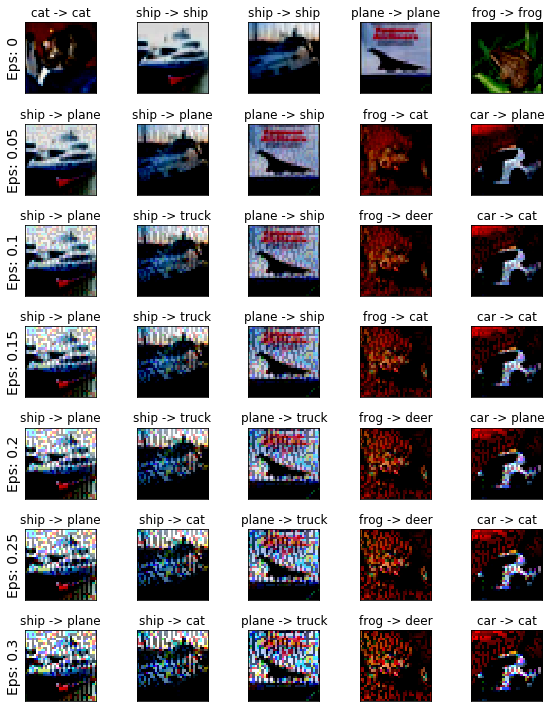

In [71]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        #plt.imshow(ex, cmap="gray")
        plt.imshow(np.transpose(ex, (1, 2, 0)))
plt.tight_layout()
plt.show()

### Test accuracy after adversarial training

In [152]:
correct = 0 
total = 0 
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('accuracy: %d'%(100*correct/total)+"%")

accuracy: 72%


*Test accuracy dropped from 76% to 72% after adversarial training*

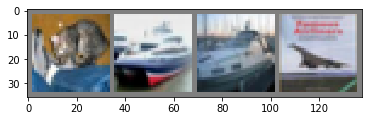

GroundTruth:   cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [36]:
images = images.to('cuda')
outputs = model(images)
_, predicted = torch.max(outputs,1)
print('Predicted: ',' '.join('%5s'%classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship plane plane


In [44]:
correct = 0 
total = 0 
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('accuracy: %d'%(100*correct/total)+"%")

accuracy: 76%


In [323]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 68 %
Accuracy of  bird : 61 %
Accuracy of   cat : 37 %
Accuracy of  deer : 53 %
Accuracy of   dog : 47 %
Accuracy of  frog : 65 %
Accuracy of horse : 57 %
Accuracy of  ship : 80 %
Accuracy of truck : 64 %


In [156]:
def predict(model,image):
    model.eval()
    with torch.no_grad():
        output = model(image).squeeze(0)
        return torch.max(output,0)[1].item()

In [113]:
def addNoise(image,scale=100):
    noise = torch.rand((3,32,32))
    return noise/scale+image

In [140]:
cat_data=testset[0][0]

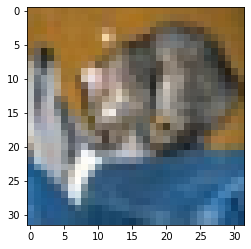

In [142]:
squeezed_cat = cat_data.squeeze(0)
imshow(cat_data.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


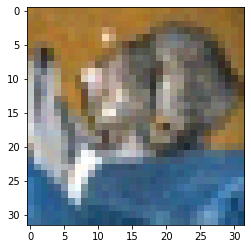

In [143]:
imshow(addNoise(squeezed_cat,scale = 10))

In [189]:
def perturb(dataset,scale=100):
    result = []
    for data in dataset:
        result.append( (addNoise(data[0],scale),data[1]) )
    return result

In [131]:
def extract_class(data_iterator,class_index):
    result = []
    for data in data_iterator:
        if data[1]==class_index:
            result.append(data)
    return result

In [242]:
def plotClassification(pred_count,dist_pred_count):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    axes[0].bar([classes[i] for i in pred_count.keys()],pred_count.values())
    axes[1].bar([classes[i] for i in dist_pred_count.keys()],dist_pred_count.values())

In [231]:
def plotClassification(pred_count,dist_pred_count):
    indices = list(pred_count.keys())
    width = np.min(np.diff(indices))/3
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,pred_count.values(),width,color='b',label='-Ymin')
    ax.bar(indices,dist_pred_count.values(),width,color='r',label='Ymax')
    ax.set_xlabel('Prediction Variation')
    plt.show()

In [202]:
def predictAndCount(model,data_set):
    #data_set = extract_class(testset,classes.index(label))
    pred_count = Counter()
    for data in data_set:
        pred_count[predict(model,data[0].unsqueeze(0))]+=1
    return pred_count

In [248]:
def attack(model,label,scale = 100):
    data_set = extract_class(testset,classes.index(label))
    dist_dataset = perturb(data_set,scale)
    pred_count = predictAndCount(model,data_set)
    dist_pred_count = predictAndCount(model,dist_dataset)
    plotClassification(pred_count,dist_pred_count)
    return pred_count,dist_pred_count

In [291]:
def showSample(dataset,n_sample=5):
    sample = []
    for i in range(n_sample):
        sample.append(dataset[i][0])
    imshow(torchvision.utils.make_grid(sample))    

In [304]:
def printDict(dic):
    result = '{'
    for key,value in dic.items():
        result += classes[key] +": "+ str(value) +" ,"
    print(result+ "}")

## Cat vs Dog

### Sample dogs

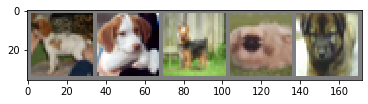

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


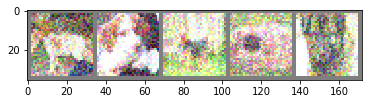

In [293]:
dog_data = extract_class(testset,5)
dist_dog_data = perturb(dog_data,1)
showSample(dog_data,5)
showSample(dist_dog_data)

### Sample cats

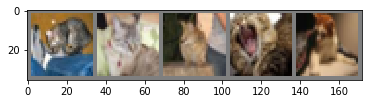

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


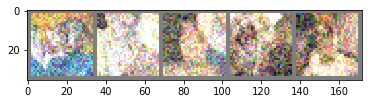

In [298]:
cat_data = extract_class(testset,3)
dist_cat_data = perturb(cat_data,1)
showSample(cat_data,5)
showSample(dist_cat_data)

### Distorted cat vs Distorted dogs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


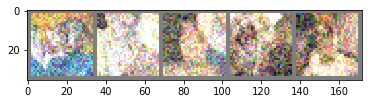

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


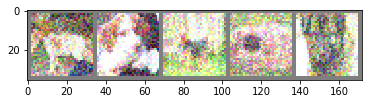

In [316]:
showSample(dist_cat_data)
showSample(dist_dog_data)

### Distorting dogs

{dog: 576 ,bird: 69 ,deer: 35 ,cat: 127 ,horse: 73 ,truck: 44 ,frog: 47 ,car: 10 ,ship: 13 ,plane: 6 ,}
{ship: 159 ,dog: 588 ,cat: 75 ,truck: 25 ,plane: 64 ,bird: 29 ,horse: 58 ,car: 2 ,}


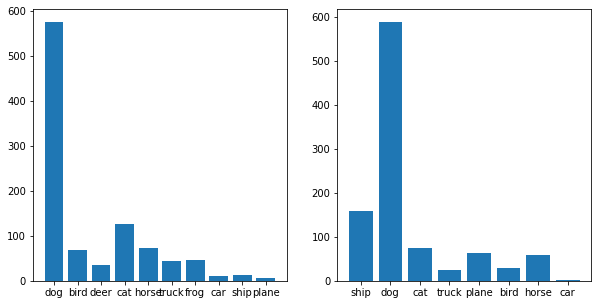

In [306]:
pred_count,dist_pred_count = attack(model,'dog',.3)
printDict(pred_count)
printDict(dist_pred_count)

### Distorting cats

{cat: 239 ,dog: 324 ,truck: 84 ,deer: 56 ,horse: 62 ,bird: 67 ,frog: 107 ,ship: 33 ,car: 17 ,plane: 11 ,}
{cat: 240 ,dog: 325 ,truck: 82 ,deer: 56 ,horse: 63 ,bird: 66 ,frog: 107 ,ship: 33 ,car: 17 ,plane: 11 ,}


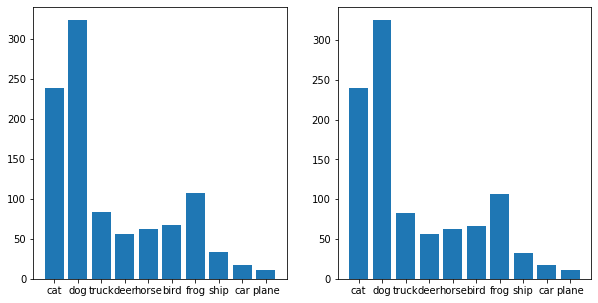

In [308]:
pred_count,dist_pred_count = attack(model,'cat',100)
printDict(pred_count)
printDict(dist_pred_count)

## Ships vs Planes

### Sample Ships

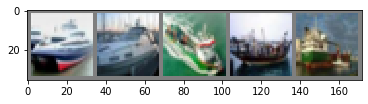

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


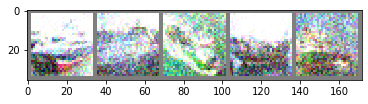

In [292]:
ship_data = extract_class(testset,8)
dist_ship_data = perturb(ship_data,1)
showSample(ship_data,5)
showSample(dist_ship_data)

### Sample Planes

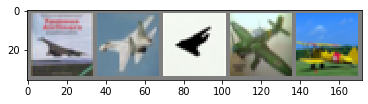

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


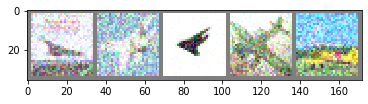

In [311]:
plane_data = extract_class(testset,0)
dist_plane_data = perturb(plane_data,1)
showSample(plane_data,5)
showSample(dist_plane_data)

### Distorted Ships vs Distorted Planes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


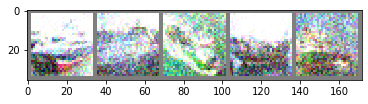

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


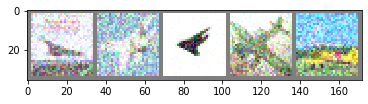

In [312]:
showSample(dist_ship_data)
showSample(dist_plane_data)

### Distorted Ships

{ship: 623 ,car: 77 ,truck: 61 ,dog: 19 ,plane: 162 ,deer: 10 ,cat: 18 ,frog: 7 ,horse: 9 ,bird: 14 ,}
{ship: 668 ,plane: 196 ,dog: 45 ,car: 20 ,truck: 22 ,cat: 20 ,bird: 17 ,horse: 8 ,deer: 3 ,frog: 1 ,}


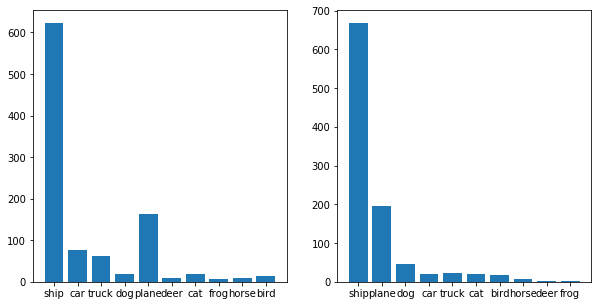

In [313]:
pred_count,dist_pred_count = attack(model,'ship',1)
printDict(pred_count)
printDict(dist_pred_count)

### Distorted Planes

{ship: 106 ,plane: 606 ,horse: 20 ,frog: 13 ,truck: 87 ,bird: 78 ,cat: 14 ,dog: 21 ,deer: 18 ,car: 37 ,}
{ship: 154 ,plane: 604 ,horse: 28 ,dog: 44 ,truck: 40 ,bird: 79 ,cat: 30 ,deer: 11 ,car: 7 ,frog: 3 ,}


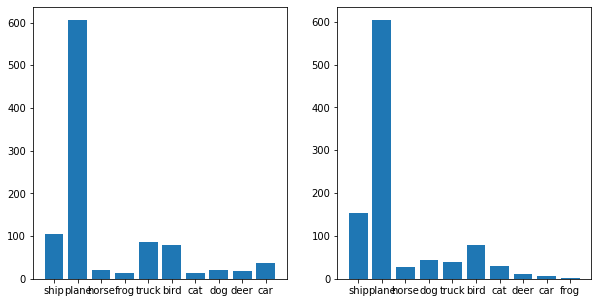

In [314]:
pred_count,dist_pred_count = attack(model,'plane',1)
printDict(pred_count)
printDict(dist_pred_count)